# Label Engineering and Exploratory model training
___

#### Label Engineering
* 1.1 Label creation
* 1.2 Dropping interim features
* 1.3 Train test strategy
* 1.4 CatBoost Classifier

#### Exploratory Model Training
* 2.2 Predicting offer completion
* 2.3 Predicting offer completion after viewing
* 2.4 Predicting responsiveness
* 2.5 Predicting responsiveness binary
* 2.6 Who to target?
* 2.7 Further Analysis

In [1]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [7]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
import joblib
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import MetricVisualizer
from sklearn.preprocessing import LabelEncoder
import timeit

from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, \
recall_score, f1_score
from sklearn.model_selection import ParameterGrid

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, GroupShuffleSplit
import seaborn as sns

%load_ext autoreload
%autoreload 2
%aimport src.models.train_model
%aimport src.data.make_dataset

%aimport src.utilities.cf_matrix

from src.data import make_dataset
from src.utilities import cf_matrix
from src.data.make_dataset import save_file
from src.models import train_model
from src.models.train_model import grid_search_results, generate_folds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,offer_spend,completed,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,37.67,6.75,5.0,1.0,1.0,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,37.67,1.0,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1.0,2.0,2.0,2.0,2.0,2.0,17.78,0.00,49.39,1.00,0.0,1.0,1.0,1.00,1,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,0.00,NaN,NaN,NaN,NaN,,,,,,,49.39,0.0,0.758621,5.50,1.75,19.89,17.78,3.616364,10.160000
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0.0,1.0,2.0,5.0,5.0,5.0,23.93,0.00,48.28,7.00,10.0,1.0,1.0,1.25,1,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,87.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,NaN,NaN,j,,,,,,48.28,1.0,0.318841,5.50,11.75,19.89,91.10,3.616364,7.753191
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,48.28,0.00,0.00,0.0,1.0,1.0,5.25,1,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,0.00,NaN,j,,b,,,,48.28,1.0,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,1.09,9.75,20.0,1.0,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,1.09,0.0,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

### 1.1 Label creation

We can define labels to categorise offer status by 7 mutually exclusive options:

1. Completed without being viewed at all
2. Completed before being viewed
3. Completed and viewed, however spending when viewed was not increased above base no offer influence spending rate.
4. Completed and when viewed, spending increased above base spending rate
5. Incomplete and when viewed, spending increased above base spending rate
6. Didn't complete or view
7. Unresponsive, incomplete but did view.

These aim to cover the following key questions:

* Whether the offer was completed
* Whether the offer was viewed
* Was the customer responsive to viewing the offer (did viewing the offer increase spending).
* Would the customer have completed the offer without viewing it.

In [14]:
separation = {'unresponsive': 1,
              'no_complete_no_view': 2,
              'incomplete_responsive': 3,
              'completed_responsive': 4,
              'complete_anyway': 5,
              'completed_before_viewed': 6, 
              'completed_not_viewed': 7}

In [5]:
def label_creater(df, label_grid=None):
    
    '''
    Creates label column based on label_grid dictionary mapping criteria
    Drops features that would lead to data leakage
        
    Parameters
    ----------
    df:  DataFrame
    label_grid: dictionary to assign labels
    dictionary keys as follows, numerical label values to be assigned.
    e.g. 
    {'unresponsive': 7,
     'no_complete_no_view': 6,
     'incomplete_responsive': 5,
     'completed_responsive': 4,
     'complete_anyway': 3,
     'completed_before_viewed': 2, 
     'completed_not_viewed': 1}
            
    Returns
    -------
    DataFrame
    '''  
       
    df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0))\
                                  * label_grid['completed_not_viewed']
    
    df['completed_before_viewed'] = (((df.completed == 1) & (df.viewed == 1)) 
                                       & (df.received_spend > df.difficulty)
                                     ) * label_grid['completed_before_viewed']
    
    # Required completion spending per time left < base rate
    df['complete_anyway'] = (((df.completed == 1) & (df.viewed == 1)) 
                                & (df.viewed_spend / df.viewed_days_left\
                                   <= df.amount_per_day_not_offer)\
                             )* label_grid['complete_anyway']
    
    # Required completion spending per time left > base rate
    df['completed_responsive'] = (((df.completed == 1) & (df.viewed == 1) \
                                   & ~(df.received_spend > df.difficulty))
                                   & (((df.viewed_spend / df.viewed_days_left \
                                        > df.amount_per_day_not_offer) 
                                    | (pd.isna(df.amount_per_day_not_offer) 
                                       & ~(df.received_spend > df.difficulty))
                                    )))* label_grid['completed_responsive']
    
    # Didn't complete, spending wasn't increased above base spending
    df['incomplete_responsive'] = (((df.completed == 0) & (df.viewed == 1)) 
                                     & ((((df.viewed_spend / df.viewed_days_left) \
                                          > df.amount_per_day_not_offer))
                                       | ((df.viewed_spend > 0) \
                                          & pd.isna(df.amount_per_day_not_offer)
                                         )))* label_grid['incomplete_responsive']
        
    df['no_complete_no_view'] = ((df.completed == 0) & (df.viewed == 0))* \
                                label_grid['no_complete_no_view']
    
    df['unresponsive'] = ((df['completed_not_viewed']==0) & 
                          (df['completed_before_viewed']==0) & 
                          (df['complete_anyway']==0) & 
                          (df['completed_responsive']==0) & 
                          (df['incomplete_responsive']==0) & 
                          (df['no_complete_no_view']==0)
                          )* label_grid['unresponsive']  
    
    df2 = (df[['completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 
                      'completed_responsive', 'incomplete_responsive', 'unresponsive', 
                      'no_complete_no_view']])
    
        
    df['label'] = df[['completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 
                      'completed_responsive', 'incomplete_responsive', 'unresponsive', 
                      'no_complete_no_view']].sum(axis=1)
    
    df.drop(['received_spend',
            'viewed_spend',
            'viewed_days_left',
            'remaining_to_complete',
            'viewed_in_valid',
            'viewed',
            'spend>required',
            'offer_spend',
            'completed',
            'completed_not_viewed',
            'completed_before_viewed',
            'complete_anyway',
            'completed_responsive',
            'incomplete_responsive',
            'no_complete_no_view',
            'unresponsive',], axis=1, inplace=True)
    
    return df

### 1.2 Dropping interim features.
To build a model that can predict whether future offers will be completed, we need to drop any features that provide data leakage.

Hence we drop the following:

* received_spend
* viewed_spend
* viewed_days_left
* remaining_to_complete
* viewed_in_valid
* viewed
* spend>required
* offer_spend

Note that these features are embeded as historical features, and this is a clear distinction. We cannot for instance have a feature indicating whether the current offer was viewed, as this directly increases the chance that it will be completed. We can, howver have features that represent the customer's previous tendancy/frequency to view offers.
            
The following are converted into a single feature 'label' with the original features dropped.
            
* completed
* completed_not_viewed
* completed_before_viewed
* complete_anyway
* completed_responsive
* incomplete_responsive
* no_complete_no_view
* unresponsive

### 1.3 Train test strategy

To build a predictive model, our test data needs to be in the future relative to our training data. Since we have embedded historical customer data in each observation, predicting a previous observation in time using a model trained on future data for the same customer would leak data and not be a true test of the predictive power of the model. 

We will therefore sort the data by 'time_days' and then use sklearn train_test_split to split the data without shuffling. 

### 1.4 CatBoost Classifier

The model will be trained using a CatBoost classifier.

CatBoost is a gradient boosting algorithm that has very good default parameters and is particularly effective at using categorical variables out of the box. 
* Statistics and combinations of categorical features are calculated internally and utilised as features in the model. 
* It has good visualisation options with the ability to plot train and test loss in real time as a model trains. 
* Setting early stopping means we do not need to optimize the number of iterations, the model will automatically stop training once test loss starts rising for a given number of iterations. 
* There is GPU support allowing for fast training.


Setting default hyper parameters:
* CatBoost uses symmetrical trees by default with a depth of 6.
* CatBoost is able to handle NaN values automatically hence we do not need to remove or impute these.
* An optimal learning rate is calculated internally by the algorithm based on the dataset provided.
* After initial training exploration we will utilise grid search to further optimise hyper parameters.

In [11]:
# CatBoost requires assignment of categorical features in order to take
# advantage of them internally, rather than one hot encoding.
cat_features = [0,4,5,92,93,94,95,96,97]

In [12]:
df.drop(['received_spend',
        'viewed_spend',
        'viewed_days_left',
        'remaining_to_complete',
        'viewed_in_valid',
        'viewed',
        'spend>required',
        'offer_spend',
        'completed',
        ], axis=1, inplace=True)

# Categorical features are as follows:
df.iloc[:, cat_features].head(10)

,person,gender,id,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30
0,78afa995795e4d85b5d9ceeca43f5fef,0,6,,,,,,
1,78afa995795e4d85b5d9ceeca43f5fef,0,9,,,,,,
2,78afa995795e4d85b5d9ceeca43f5fef,0,1,j,,,,,
3,78afa995795e4d85b5d9ceeca43f5fef,0,7,j,,b,,,
4,a03223e636434f42ac4c3df47e8bac43,0,0,,,,,,
5,a03223e636434f42ac4c3df47e8bac43,0,8,,,,,,
6,a03223e636434f42ac4c3df47e8bac43,0,9,,i,,,,
7,a03223e636434f42ac4c3df47e8bac43,0,0,,i,j,,,
8,a03223e636434f42ac4c3df47e8bac43,0,0,,i,j,a,,
9,e2127556f4f64592b11af22de27a7932,1,4,,,,,,


In [15]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = label_creater(df, label_grid=separation)

# Exploratory Model Training
___


###  Analysis using various label combinations
The following function performs training using a CatBoost classifier.

exploratory training provides options to:
* Remove specified features
* Assign target labels
* Specify CatBoost hyper parameters
* Display results including Sklearn Classification report and detailed confusion matrix.

This allows for quick training using a variety of options to optimise results.

In [16]:
def exploratory_training(labels=None, labels_compact=None, drop_features=None, 
                         feature_engineering=True, verbose=500, return_model=False, 
                         data='../../data/interim/transcript_final_optimised.joblib', 
                         **params):
    '''
    Function to help manage and train CatBoost Classifer under
    varying conditions. 
    These include:
    > Which features to remove
    > How to assign target labels
    > CatBoost hyper parameters to use
    > Whether to return model or accuracy score
    > Whether to display detailed results   
        
    Parameters
    -----------
    labels: dictionary to assign labels
    dictionary keys as follows, numerical label values to be assigned.
    e.g. for greatest label category separation: 
    {'unresponsive': 7,
     'no_complete_no_view': 6,
     'incomplete_responsive': 5,
     'completed_responsive': 4,
     'complete_anyway': 3,
     'completed_before_viewed': 2, 
     'completed_not_viewed': 1}
     
    labels_compact: dictionary, assigns labels under multiple 
    categories for purpose of confusion matrix output, e.g.
    {'failed':0, 'completed':1}
            
    drop_features - list of features to remove, default None
    features_engineering - boolean, default True. If not True, removes 
    all engineered features leaving original base features.
    verbose - int, displays results of training at each iteration. If 
    not false also displays classification report and confusion matrix.
    return_model - boolean, default False. If True, returns trained
    model, otherwise returns model accuracy score.
    data - path to .joblib file of DataFrame
    **params - dictionary of CatBoost hyper parameters.    
    '''
    
    df = joblib.load(data)
    
    # assign labels
    df = label_creater(df, label_grid=labels)
    
    # categorical feature assignment
    cat_features_name = ['person', 'gender', 'id', 'offer_7', 'offer_14', 'offer_17', 
                         'offer_21', 'offer_24', 'offer_30']
    

    df.sort_values('time_days', inplace=True)
    X = df.drop('label', axis=1)
    
    # Selects only base features for X
    if not feature_engineering:    
        X = X[['person', 'age', 'income', 'signed_up', 'gender', 'id', 'rewarded',
           'difficulty', 'reward', 'duration', 'mobile', 'web', 'social', 'bogo',
           'discount', 'informational', 'time_days']]
    
    # Removes specified features
    if drop_features is not None:        
        X.drop(drop_features, axis=1, inplace=True)
    
    # Assigns columns index location of categorical features
    cat_features = [X.columns.get_loc(i) for i in cat_features_name if i in X.columns]
    
    y = df.label
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, 
                                                        random_state=42)
    
    # Assigns weights to labels since these are unbalanced
    weights = [df.label.value_counts().sum() / df.label.value_counts()[i] for i in 
               set(labels.values())]

    # utilised by CatBoost to assign train and test data, needed to perform early stopping when
    # test accuracy falls beyond a specified number of interations
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    # model training
    model = CatBoostClassifier(
        iterations=7000,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        task_type='GPU',
        cat_features=cat_features,
        class_weights= weights,
        verbose=verbose,
        **params)    

    model.fit(train_pool,
          eval_set=test_pool,
          verbose=verbose,
          plot=False);
    
    # if multiple labels under similar categories, specify these categories
    if not labels_compact:
        labels_compact=labels
          
    preds_class = model.predict(X_test)
    print("")

    # displays learning rate, weights and results
    if verbose:
        display(F'Learning Rate set to: {model.get_all_params()["learning_rate"]}')
        display(F'Accuracy Score: {accuracy_score(y_test, preds_class)}')
        display(F'Weights: {weights}')
        matrix = confusion_matrix(y_test, preds_class)
        width = len(labels_compact)*2 + 1
        cf_matrix.make_confusion_matrix(matrix, figsize=(width,width), cbar=False, 
                                        categories=labels_compact.keys(), group_names = 
                                        ['True Neg', 'False Pos', 'False Neg', 'True Pos'])
    
        print(classification_report(y_test, preds_class, target_names=list(labels_compact.keys()))) 
        
    if return_model:
        return model
        
    else:
        return accuracy_score(y_test, preds_class)

We will peform some exploratory model training using the default CatBoost parameters. The default parameters are chosen internally by the CatBoost algorithm and dependent on the dataset being trained on.

### 2.1 Full label separation
We first perform training with complete granular separation of labels into seven categories. 

0:	learn: 1.9122181	test: 1.9139031	best: 1.9139031 (0)	total: 41.1ms	remaining: 4m 47s
500:	learn: 1.1183939	test: 1.2395760	best: 1.2395667 (499)	total: 16s	remaining: 3m 28s
1000:	learn: 1.0367527	test: 1.2250881	best: 1.2246932 (988)	total: 33.7s	remaining: 3m 21s
bestTest = 1.224693211
bestIteration = 988
Shrink model to first 989 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.46801258521237543'

'Weights: [4.342061820458815, 6.03218663503361, 6.109002082332212, 3.9362679327071937, 26.981605942695438, 13.952259008597037, 12.91298459454884]'

                         precision    recall  f1-score   support

           unresponsive       0.65      0.29      0.40      3823
    no_complete_no_view       0.64      0.62      0.63      2890
  incomplete_responsive       0.46      0.67      0.55      2096
   completed_responsive       0.55      0.33      0.41      3042
        complete_anyway       0.30      0.50      0.37       830
completed_before_viewed       0.31      0.41      0.35      1389
   completed_not_viewed       0.32      0.72      0.44      1186

               accuracy                           0.47     15256
              macro avg       0.46      0.51      0.45     15256
           weighted avg       0.53      0.47      0.46     15256



0.46801258521237543

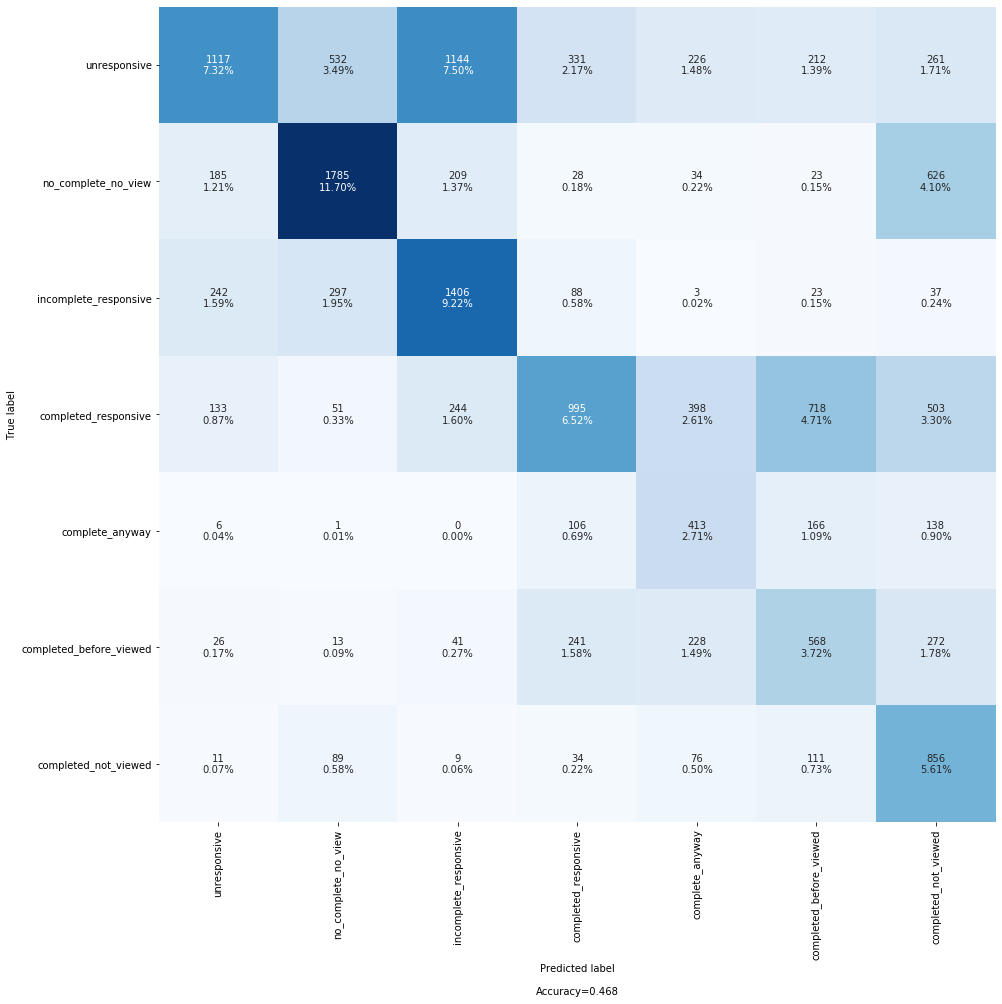

In [138]:
separation = {'unresponsive': 1,
              'no_complete_no_view': 2,
              'incomplete_responsive': 3,
              'completed_responsive': 4,
              'complete_anyway': 5,
              'completed_before_viewed': 6, 
              'completed_not_viewed': 7}

exploratory_training(labels=separation)

Here we can see an overall accuracy of 46.8%. Since classes are imbalanced, we have weighted each label inversely proportionaly to its proportion within the dataset. With seven possible labels, overall accuracy is low with a poor ability to distinguish between categories.

* Complete_anyway has very low precision (0.3), often incorrectly being predicted as unresponsive or complete_before_viewed. This would make sense as these three categories share the similarity of low demand elasticity.
* Completed_before_viewed has a precision of (0.31), more often classified as completed responsive. Again these two categories are very similar, both being completed.
* Completed_not_viewed has a precision of 0.32, more often classified as no_complete_no_view.

Going forward I will combine these three categories as they all represent completion of an offer without being responsive. Simplyfying will improve accuracy and clarity.

In particular we have low f1-scores for incomplete responsive, completed responsive and unresponsive.

This could be due to the way the labels have been categorised, or that these labels are simply too similar to distinguish to a high degree of accuracy.

### 2.2 Predicting offer completion

Simplifying to a binary classification complete vs didn't complete:

1. Completed 
2. Didn't complete

0:	learn: 0.6788512	test: 0.6781513	best: 0.6781513 (0)	total: 73ms	remaining: 8m 31s
500:	learn: 0.3301724	test: 0.3442766	best: 0.3442766 (500)	total: 34.4s	remaining: 7m 26s
1000:	learn: 0.3150239	test: 0.3336551	best: 0.3335454 (985)	total: 1m 8s	remaining: 6m 48s
1500:	learn: 0.3038893	test: 0.3297453	best: 0.3297340 (1498)	total: 1m 41s	remaining: 6m 13s
bestTest = 0.3274103616
bestIteration = 1946
Shrink model to first 1947 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.8519271106449922'

'Weights: [1.7864302777647665, 2.2715685398612226]'

              precision    recall  f1-score   support

      failed       0.93      0.81      0.86      8809
   completed       0.78      0.91      0.84      6447

    accuracy                           0.85     15256
   macro avg       0.85      0.86      0.85     15256
weighted avg       0.86      0.85      0.85     15256



0.8519271106449922

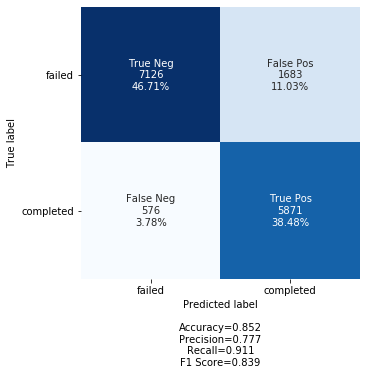

In [19]:
complete = {'completed_not_viewed': 1, 
        'completed_before_viewed': 1, 
        'complete_anyway': 1,
        'completed_responsive': 1,
        'incomplete_responsive': 0,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'failed':0, 'completed':1}

exploratory_training(labels=complete, labels_compact=labelling)

With a binary classification we can significantly improve accuracy, up to 85.2%.

Weighted precision and recall are also high at 0.86 and 0.85 respectively with an f1-score of 0.85. 

However we now lose the ability to differentiate between customers that are responsive to offers and those that would have completed anyway.

### 2.3 Predicting offer completion after viewing

Splitting into offers that were completed without or before being viewed:

1. Completed before viewing
2. Complete after viewing
2. Didn't complete

0:	learn: 1.0807158	test: 1.0814416	best: 1.0814416 (0)	total: 25.2ms	remaining: 2m 56s
500:	learn: 0.6563222	test: 0.6989351	best: 0.6989351 (500)	total: 19.8s	remaining: 4m 17s
1000:	learn: 0.6218076	test: 0.6861597	best: 0.6861546 (999)	total: 33.4s	remaining: 3m 20s
1500:	learn: 0.5940539	test: 0.6800690	best: 0.6800115 (1495)	total: 58s	remaining: 3m 32s
bestTest = 0.67738628
bestIteration = 1900
Shrink model to first 1901 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.7109989512323021'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.93      0.76      0.84      8809
 complete after       0.60      0.61      0.60      3872
complete before       0.43      0.69      0.53      2575

       accuracy                           0.71     15256
      macro avg       0.65      0.69      0.66     15256
   weighted avg       0.76      0.71      0.73     15256



0.7109989512323021

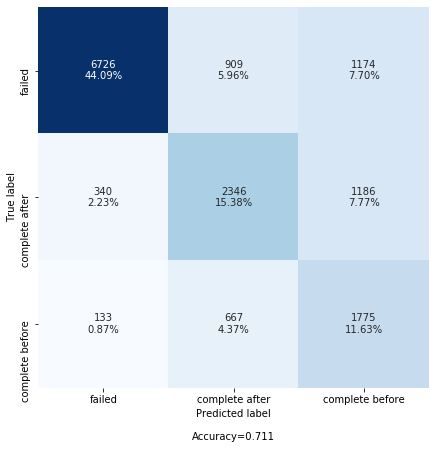

In [104]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, labels_compact=labelling)

Using this model we still retain a high ability to classify failures to complete, with an f1-score of 0.84. Overall accuracy is at 71%, with a fall in accuracy vs the binary model mainly due to the reduced ability to distinguish between complete after and complete before.

Complete after and complete before have lower f1-scores, 0.6 and 0.53 respectively. This model is a compromise between the two previous.

### 2.4 Predicting responsiveness

Since incomplete responsive also increases spending without loss of revenue from completion of offers, we can assign labels to diferentiate and target this category as well.

* Complete anyway - Would have completed without having viewed offer
* Responsive - spending was increased by viewing offer whether completed or not 
* Unresponsive - Spending did not increase by viewing offer, and didn't complete 

0:	learn: 1.0842536	test: 1.0842491	best: 1.0842491 (0)	total: 31.5ms	remaining: 3m 40s
500:	learn: 0.7290280	test: 0.7444413	best: 0.7444413 (500)	total: 13.5s	remaining: 2m 55s
1000:	learn: 0.6969082	test: 0.7303352	best: 0.7303352 (1000)	total: 28s	remaining: 2m 47s
1500:	learn: 0.6719579	test: 0.7253108	best: 0.7252868 (1495)	total: 41.9s	remaining: 2m 33s
bestTest = 0.7250033629
bestIteration = 1533
Shrink model to first 1534 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.6315547981122182'

'Weights: [2.5247252747252746, 2.3938300276173736, 5.371241461868882]'

                 precision    recall  f1-score   support

   Unresponsive       0.78      0.66      0.71      6713
     responsive       0.61      0.48      0.54      5138
complete anyway       0.50      0.81      0.62      3405

       accuracy                           0.63     15256
      macro avg       0.63      0.65      0.62     15256
   weighted avg       0.66      0.63      0.63     15256



0.6315547981122182

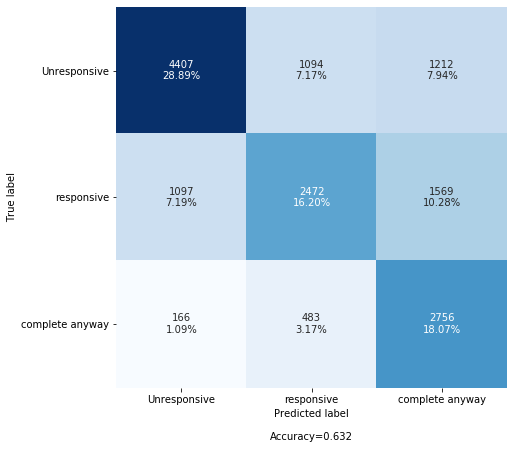

In [21]:
responsiveness = {'completed_not_viewed': 2, 
        'completed_before_viewed': 2, 
        'complete_anyway': 2,
        'completed_responsive': 1,
        'incomplete_responsive': 1,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'Unresponsive':0, 'responsive':1, 'complete anyway':2}

exploratory_training(labels=responsiveness, labels_compact=labelling)

Accuracy drops further here to 0.63. It appears that responsiveness to an offer is fairly difficult to categorise with precision of 0.61, recall of 0.48 and f1-score of 0.54

### 2.5 Predicting responsiveness binary

To simplify the previous model further we can aim to target only customers that have a positive response to offers. We then lump all responsive labels into one category, and unresponsive (whether complete or not) into another.

1. Responsive
2. Unresponsive

0:	learn: 0.6882945	test: 0.6891379	best: 0.6891379 (0)	total: 24.4ms	remaining: 2m 51s
500:	learn: 0.5468082	test: 0.5642242	best: 0.5642081 (499)	total: 10.6s	remaining: 2m 17s
1000:	learn: 0.5278644	test: 0.5561404	best: 0.5561291 (999)	total: 20.9s	remaining: 2m 5s
bestTest = 0.5552298516
bestIteration = 1106
Shrink model to first 1107 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.7117855270057682'

'Weights: [1.7174475941728773, 2.3938300276173736]'

              precision    recall  f1-score   support

Unresponsive       0.82      0.72      0.77     10118
  Responsive       0.56      0.69      0.62      5138

    accuracy                           0.71     15256
   macro avg       0.69      0.71      0.69     15256
weighted avg       0.73      0.71      0.72     15256



0.7117855270057682

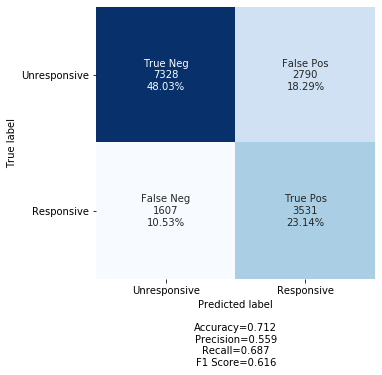

In [29]:
responsiveness2 = {'completed_not_viewed': 0, 
        'completed_before_viewed': 0, 
        'complete_anyway': 0,
        'completed_responsive': 1,
        'incomplete_responsive': 1,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'Unresponsive':0, 'Responsive':1}

exploratory_training(labels=responsiveness2, labels_compact=labelling)

Due to simplification of the mode, accuracy in this case has jumped back up to 0.71. 

From a business perspective, since there is no marginal cost to providing offers to unresponsive customers that are not expected to complete, we may as well target these customer as well.

In the following model we extend this logic.

### 2.6 Who to target?

Since targetting an unresponsive customer that we do not expect to complete will not result in reduced revenue, from a business perspective we should target these customers anyway. These customers can be given informational ads instead.

The following label categorisation makes the distinction of targetting anyone except those we expect to complete regardless of receiving or not receiving an offer.

0:	learn: 0.6826571	test: 0.6824203	best: 0.6824203 (0)	total: 21.9ms	remaining: 2m 33s
500:	learn: 0.4153467	test: 0.4242098	best: 0.4241970 (499)	total: 10.4s	remaining: 2m 15s
1000:	learn: 0.3928566	test: 0.4202688	best: 0.4200316 (951)	total: 20.7s	remaining: 2m 3s
bestTest = 0.4200316056
bestIteration = 951
Shrink model to first 952 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.7349239643418982'

'Weights: [1.2287679618532121, 5.371241461868882]'

               precision    recall  f1-score   support

Target offers       0.96      0.69      0.80     11851
Informational       0.45      0.90      0.60      3405

     accuracy                           0.73     15256
    macro avg       0.71      0.79      0.70     15256
 weighted avg       0.85      0.73      0.76     15256



0.7349239643418982

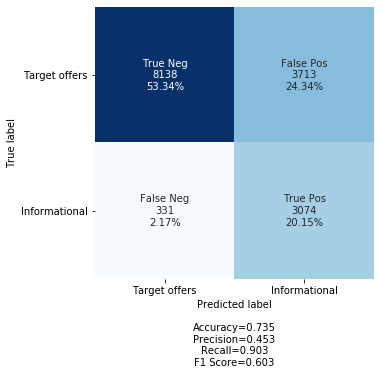

In [36]:
complete = {'completed_not_viewed': 1, 
        'completed_before_viewed': 1, 
        'complete_anyway': 1,
        'completed_responsive': 0,
        'incomplete_responsive': 0,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'Target offers':0, "Informational":1}

exploratory_training(labels=complete, labels_compact=labelling)

Here we see an accuracy of 0.735. Target offers has a precision of 0.96 indicating we are rarely targetting offers at the wrong customers and therefore will not lose much revenue from giving away offers too freely. Recall, however was lower at 0.69 meaning we are missing 0.39 of customers that should ideally be targetted.

### 2.7 Further Analysis

Offer responsiveness relies on a calculation of the base spending rate of a customer to determine whether they increase spending beyond their normal habits when under the influence of an offer. Since at maximum only 30 days of spending is available, this metric is not statistically a very reliable representation of a customer's base spending rate. Furthermore if an offer is only given on day 7 for instance, we only have 7 days of historical spending to establish a base rate. This means the label categorisations with respect to responsiveness that we are trying to predict on could easily be incorrect. 

If longer duration experimental data was available giving more time to establish a base spending rate, these responsiveness label categorisations would become more accurate. For the current data however we will simplify and assume:

* Complete after viewing indicates responsiveness
* Complete before viewing indicates unresponsiveness

These label classifications do not rely on establishment of a base spending rate.

To further continue with the analysis, we will perform cross validation and grid search to optimize parameters for the following two cases.

1. Binary classification (default parameter accuracy 85.2%)
    * Complete
    * Fail to complete
        
        
2. Multiclass Classification (default parameter accuracy 71%)
    * Complete before viewing  (unresponsive)
    * Complete after viewing  (responsive)
    * Fail to complete